In [1]:
import numpy as np
import matplotlib.pyplot as plt

import holodeck as holo
from holodeck import sams
from holodeck import utils, plot
from holodeck.constants import MSOL, YR, GYR
import scipy.constants as sc
import matplotlib as mpl


rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["font.size"]=15
plt.rcParams["figure.figsize"]=(5,3.5)
plt.rcParams["xtick.direction"]="in"
plt.rcParams["ytick.direction"]="in"
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['legend.handlelength'] = 1.2
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.columnspacing'] = 0.5
plt.rcParams['legend.framealpha'] = 1

In [9]:
def get_hc_ideal( allparams, Nsamps , fgw= 1/sc.year , SAM_SHAPE = (20, 21, 22)  ):

    phi0 , mchar0_log10, alpha0, zbeta, qgamma, time_norm, zbeta1, mu, alpha, scatter_dex = allparams

    if type(phi0) in [float, int]:
        phi0 = [phi0] * Nsamps
    if type(mchar0_log10) in [float, int]:
        mchar0_log10 = [mchar0_log10] * Nsamps
    if type(alpha0) in [float, int]:
        alpha0 = [alpha0] * Nsamps
    if type(zbeta) in [float, int]:
        zbeta = [zbeta]* Nsamps
    if type(qgamma) in [float, int]:
        qgamma = [qgamma]* Nsamps
    if type(time_norm) in [float, int]:
        time_norm = [time_norm]* Nsamps
    if type(zbeta1) in [float, int]:
        zbeta1 = [zbeta1]* Nsamps
    if type(mu) in [float, int]:
        mu = [mu]* Nsamps
    if type(alpha) in [float, int]:
        alpha = [alpha]* Nsamps
    if type(scatter_dex) in [float, int]:
        scatter_dex = [scatter_dex]* Nsamps

    
    all_hc_ideal = np.zeros(Nsamps)
    for i in range(len(phi0)):
        gsmf = holo.sams.GSMF_Schechter(phiz = -0.60 ,mcharz=0.11, alphaz=-0.03, mchar0=None, \
                                    phi0 = phi0[i],mchar0_log10=mchar0_log10[i], alpha0=alpha0[i])

        # GPF
        gpf = holo.sams.GPF_Power_Law(frac_norm_allq=None, frac_norm=0.033, mref=None, mref_log10=11.0, 
                                        malpha=0.0, zbeta=zbeta[i], qgamma=qgamma[i], obs_conv_qlo=0.25, max_frac=1.0)

        # GMT
        gmt = holo.sams.GMT_Power_Law(time_norm = time_norm[i], mref0=1.0e11*MSOL, malpha=0.0\
                                    , zbeta=zbeta1[i], qgamma=-1.0 )
        # MMBulge
        mmbulge = holo.host_relations.MMBulge_Standard(mamp_log10=mu[i], mplaw=alpha[i], mref=None, \
                                                    scatter_dex=scatter_dex[i], bulge_frac=None, bulge_mfrac=0.615)
        
        sam = holo.sams.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=SAM_SHAPE)
        hc_ideal = sam.gwb_ideal(fgw)

        all_hc_ideal[i] = hc_ideal
        print(i)
        
    return all_hc_ideal, sam

In [7]:
import numpy as np
import logging
import warnings
import sys
import os
from tqdm import tqdm

logging.basicConfig(level=logging.CRITICAL)
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.CRITICAL)
logging.getLogger('holodeck').setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

class SuppressAll:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

Nsamps = 50000

phi0 = np.random.normal(-2.56, 0.4, Nsamps)
mchar0_log10 = np.random.normal(10.9, 0.4, Nsamps)
alpha0 = np.random.normal(-1.2, 0.2, Nsamps)
zbeta = np.random.normal(0.8, 0.4, Nsamps)
qgamma = np.random.normal(0.5, 0.3, Nsamps)
time_norm = (np.random.rand(Nsamps) * 4.8 + 0.2) * GYR
zbeta1 = np.random.rand(Nsamps) * 2 - 2
mu = np.random.normal(8.6, 0.2, Nsamps)
alpha = np.random.normal(1.2, 0.2, Nsamps)
scatter_dex = np.random.normal(0.32, 0.15, Nsamps * 5)
scatter_dex = scatter_dex[scatter_dex > 0.01][:Nsamps]

params = [phi0, mchar0_log10, alpha0, zbeta, qgamma, time_norm, zbeta1, mu, alpha, scatter_dex]

chunk_size = 500
all_hc_ideal_list = []

for i in tqdm(range(0, Nsamps, chunk_size)):
    end = min(i + chunk_size, Nsamps)
    current_params = [p[i:end] for p in params]
    current_nsamps = end - i
    
    with SuppressAll():
        result = get_hc_ideal(current_params, current_nsamps)
    
    all_hc_ideal_list.append(result[0])

all_hc_ideal = np.concatenate(all_hc_ideal_list, axis=0)
np.save("all_hc_ideal.npy", all_hc_ideal)

100%|█████████████████████████████████████████| 100/100 [44:34<00:00, 26.74s/it]


In [13]:
SAM_SHAPE = (40,21,22)
hc_ideal_fiducial,sam = get_hc_ideal( [-2.27 , 11.14, -1.21, 1, 0.5, 0.5*GYR, -0.5, 8.65, 1.1, 0.319],1 ,SAM_SHAPE=SAM_SHAPE)
nden = sam.static_binary_density  # this will trigger the variable to be calculated and cached.
### Integrate over log10M, q, z to get Number in each log10M, q, z bin
edges = [sam.mtot, sam.mrat, sam.redz]
Ntot_per_bin = holo.utils._integrate_grid_differential_number(edges, nden, freq=False)

### construct centered values
# (0, 1, 2)
# (M, Q, Z)
Nm = SAM_SHAPE[0]
mcent = np.zeros(Nm-1)
for i in range(Nm-1):
	mcent[i] = (sam.mtot[i]+sam.mtot[i+1])/2./MSOL

Nq = SAM_SHAPE[1]
qcent = np.zeros(Nq-1)
for i in range(Nq-1):
	qcent[i] = (sam.mrat[i]+sam.mrat[i+1])/2.


Nz = SAM_SHAPE[2]
zcent = np.zeros(Nz-1)
for i in range(Nz-1):
	zcent[i] = (sam.redz[i]+sam.redz[i+1])/2.

nden_bh = Ntot_per_bin / np.diff(np.log10(sam.mtot))[:,None,None] / np.diff(sam.mrat)[None,:,None] / np.diff(sam.redz)[None,None,:]
edges_bh = np.array([ mcent , qcent , zcent ],dtype='object')
np.save("nden_M%i_Q%i_Z%i_holov1p6_SAM_NANO15Astro.npy" %(SAM_SHAPE[0], SAM_SHAPE[1], SAM_SHAPE[2]), nden_bh)
np.save("edges_M%i_Q%i_Z%i_holov1p6_SAM_NANO15Astro.npy" %(SAM_SHAPE[0], SAM_SHAPE[1], SAM_SHAPE[2]), edges_bh, allow_pickle=True)
print(2*np.log10( hc_ideal_fiducial) )

<holodeck.sams.sam.Semi_Analytic_Model object at 0x15fca7010> :: utils.stats(rz)='-1.00e+00, -1.00e+00, -1.00e+00, -1.00e+00, 4.11e-01, 2.44e+00, 8.17e+00'
0
[-29.20965586]


Fitted mu: -30.762844459356085, Fitted sigma: 1.1183454649355418


(-5.0, 5.0)

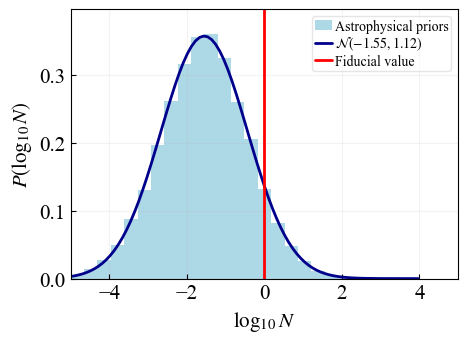

In [12]:
from scipy.stats import norm

# Fit a Gaussian to the histogram data
(mu, sigma) = norm.fit(2*np.log10(all_hc_ideal))

#all_hc_ideal = all_hc_ideal[0]
h = plt.hist(2*np.log10(all_hc_ideal ) -2*np.log10(hc_ideal_fiducial) ,label="Astrophysical priors",bins=30,density=True,color='lightblue')

plt.ylim(0,h[0].max()*1.1)
plt.xlabel(r"$\log_{10}(h_c^2(f_{\rm yr}))$")

# Plot the Gaussian fit
x = np.linspace(min(2*np.log10(all_hc_ideal)) , max(2*np.log10(all_hc_ideal)), 100)
p = norm.pdf(x, mu, sigma)
# plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian fit ($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)')
plt.plot(x-2*np.log10(hc_ideal_fiducial), p, 'k', linewidth=2, label=r'$\mathcal{N}(%.2f,%.2f)$'%(mu-2*np.log10(hc_ideal_fiducial),sigma)\
         ,color='darkblue' )
print(f"Fitted mu: {mu}, Fitted sigma: {sigma}")
# Update the y-label
plt.ylabel(r"$P(\log_{10}N)$")


# plt.plot( [2*np.log10(2.4e-15)-2*np.log10(hc_ideal_fiducial),2*np.log10(2.4e-15)-2*np.log10(hc_ideal_fiducial)],[0,h[0].max()*1.1] ,\
#          label="$h_c(f)\propto f^{-2/3}$ fit")
plt.plot( [2*np.log10(hc_ideal_fiducial)-2*np.log10(hc_ideal_fiducial),\
           2*np.log10(hc_ideal_fiducial)-2*np.log10(hc_ideal_fiducial)],[0,h[0].max()*1.1] ,label="Fiducial value",color='red',lw=2)
plt.legend(fontsize=10,loc=1,framealpha=0.5)

plt.xlabel(r"$\log_{10}N$")

plt.xlim(-5,5)

plt.savefig("hc_ideal_prior.pdf",bbox_inches='tight')